# Solving BlackJack using Monte Carlo

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dataclasses import dataclass
from collections import defaultdict
from itertools import islice
from blackjack.engine import *
from blackjack.policies import *

In [20]:
def generate_episode():
    states = []
    rewards = []
    actions = []
    game = Blackjack()

    # We append first state
    states.append((game.player.sum, game.player.usable_ace, game.dealer.card1[1]))

    if game.turn == Turn.RESOLUTION:
        action = policy_player()

    while game.check_state() == GameState.PLAYING:
        # game.print_game()

        last_turn = game.turn
        action = game.take_step(policy_player=policy_player, policy_dealer=policy_dealer)

        if last_turn == Turn.PLAYER:
            actions.append(action)

            if game.check_state() == GameState.PLAYING and game.turn == Turn.PLAYER:
                rewards.append(0)
                states.append((game.player.sum, game.player.usable_ace, game.dealer.card1[1]))

    # print(game.check_state())
    # game.print_game()
    
    # Depending on the result, we append the terminal reward, that is also the return
    if game.check_state() == GameState.LOST:
        rewards.append(-1)
    if game.check_state() == GameState.WON:
        rewards.append(1)
    if game.check_state() == GameState.DRAW:
        rewards.append(0)

    return (states, rewards, actions)


Each step is a three value python tuple having reward, state and action

In [21]:
generate_episode()

([(16, True, 3), (16, False, 3), (19, False, 3)],
 [0, 0, -1],
 [<Action.HIT: 1>, <Action.HIT: 1>, <Action.HIT: 1>])

In [52]:
V_s = defaultdict(float)
N_s = defaultdict(int)
returns = []
gamma = 1
num_episodes = 500000

for _ in range(num_episodes):
    states, rewards, actions = generate_episode()
    G = 0
    for t in range(len(states)-1, -1, -1):
        G = G*gamma + rewards[t]
        
        if states[t] not in states[:t]:
            N_s[states[t]] += 1
            V_s[states[t]] += (G - V_s[states[t]]) / N_s[states[t]]    
        

In [53]:
for key, value in islice(V_s.items(), 10):
    print(f'State: {key}, value: {value}')

State: (20, False, 1), value: 0.22661870503597106
State: (13, False, 1), value: -0.6275325615050642
State: (21, True, 2), value: 0.9640458316870798
State: (17, True, 2), value: -0.32589285714285715
State: (19, False, 7), value: -0.6806314511232554
State: (16, False, 10), value: -0.6366192523982812
State: (20, False, 12), value: 0.4775828460038988
State: (16, False, 12), value: -0.6344014610659149
State: (20, False, 11), value: 0.45823042278076276
State: (21, False, 5), value: 0.8809679529103993


In [54]:
def plot_blackjack_values(V_s):

    def get_Z(x, usable_ace, y):
        if (x, usable_ace, y) in V_s:
            return V_s[x, usable_ace, y]
        else:
            return 0
        
    def get_figure(usable_ace, ax):
        x_range = np.arange(12, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x, usable_ace, y) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)
        
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

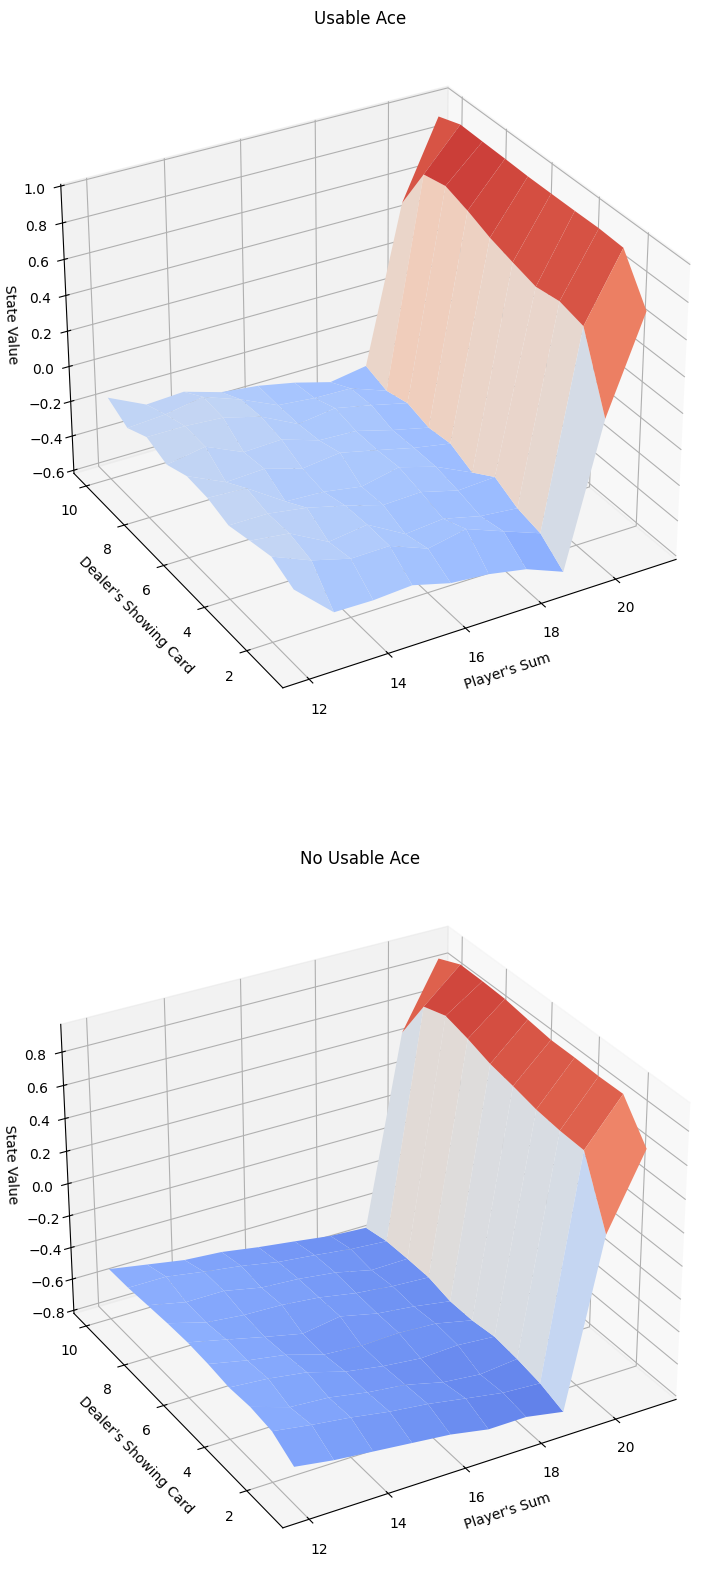

In [55]:
plot_blackjack_values(V_s)